### Imports

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

import numpy as np
import re
import string
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import os
from os import listdir
from os.path import isfile, join

import itertools

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import confusion_matrix

from keras.models import Model, load_model, Sequential
from keras.utils import np_utils
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.applications.vgg16 import VGG16
from keras_preprocessing.image import ImageDataGenerator
from keras import regularizers

from glob import glob

import PIL.Image
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/miniconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


### Load data from prior web scraping

In [2]:
recipes_part_1 = pd.read_csv('../pickles-csvs/web-scraping-pickles-csvs/tables_1-6.csv')
recipes_part_2 = pd.read_csv('../pickles-csvs/web-scraping-pickles-csvs/tables_7-12.csv')

### Preprocessing

In [3]:
recipes_part_1.dropna(inplace=True) # Drop recipes without nutrition info
recipes_part_1.drop(columns='Unnamed: 0', inplace=True) # Drop duplicate index
recipes_part_1['Nutrition Info'] = recipes_part_1['Nutrition Info'].apply(lambda x: x[1:-1].split(',')) 

recipes_part_2.drop(columns='Unnamed: 0', inplace=True) # Drop duplicate index
recipes_part_2.dropna(inplace=True) # Drop recipes without nutrition info
recipes_part_2['Nutrition Info'] = recipes_part_2['Nutrition Info'].apply(lambda x: x[1:-1].split(',')) 
recipes_part_2.drop(columns='Unnamed: 0.1', inplace=True) # Drop duplicate index

In [4]:
all_recipes = pd.concat([recipes_part_1, recipes_part_2]) # make table of all recipes

In [5]:
df = all_recipes[all_recipes['Rating'] > 3.5] # Only keep high-rated recipes

In [6]:
# Make discrete nutrition columns from nutrition info

df.loc[:, 'Calories'] = df['Nutrition Info'].map(lambda x: x[0]).astype(float)
df.loc[:, 'Fat'] = df['Nutrition Info'].map(lambda x: x[1]).astype(float)
df.loc[:, 'Carbs'] = df['Nutrition Info'].map(lambda x: x[2]).astype(float)
df.loc[:, 'Protein'] = df['Nutrition Info'].map(lambda x: x[3]).astype(float)
df.loc[:, 'Cholesterol'] = df['Nutrition Info'].map(lambda x: x[4]).astype(float)
df.loc[:, 'Sodium'] = df['Nutrition Info'].map(lambda x: x[5]).astype(float)

df.drop(columns='Nutrition Info', inplace=True) # Drop original column

In [7]:
df.to_csv('../pickles-csvs/recipe-tables/df.csv', index=False)

### Recipes by a variety of health metrics

In [8]:
df_low_cal = df[df['Calories'] <= 500] # low cal
df_low_fat = df[df['Fat'] <= 7] # low fat
df_low_carb = df[df['Carbs'] <= 25] # low carb
df_high_protein = df[df['Protein'] >= 20] # high protein
df_low_cholesterol = df[df['Cholesterol'] <= 25] # low cholesterol
df_low_sodium = df[df['Sodium'] <= 500] # low sodium

In [9]:
df_low_cal.to_csv('../pickles-csvs/recipe-tables/low_cal.csv', index=False)
df_low_fat.to_csv('../pickles-csvs/recipe-tables/low_fat.csv', index=False)
df_low_carb.to_csv('../pickles-csvs/recipe-tables/low_carb.csv', index=False)
df_high_protein.to_csv('../pickles-csvs/recipe-tables/high_protein.csv', index=False)
df_low_cholesterol.to_csv('../pickles-csvs/recipe-tables/low_cholesterol.csv', index=False)
df_low_sodium.to_csv('../pickles-csvs/recipe-tables/low_sodium.csv', index=False)

### Quick Recipes

In [10]:
df_quick = df[df['Prep Time'] <= 45]

In [11]:
df_quick.to_csv('../pickles-csvs/recipe-tables/df_quick.csv', index=False)

In [12]:
# Quick, healthy recipes

df_low_cal_quick = df_quick[df_quick['Calories'] <= 500] # low cal
df_low_fat_quick = df_quick[df_quick['Fat'] <= 7] 
df_low_carb_quick = df_quick[df_quick['Carbs'] <= 25] 
df_high_protein_quick = df_quick[df_quick['Protein'] >= 20] 
df_low_cholesterol_quick = df_quick[df_quick['Cholesterol'] <= 25] 
df_low_sodium_quick = df_quick[df_quick['Sodium'] <= 500] 

In [13]:
df_low_cal_quick.to_csv('../pickles-csvs/recipe-tables/low_cal_quick.csv', index=False)
df_low_fat_quick.to_csv('../pickles-csvs/recipe-tables/low_fat_quick.csv', index=False)
df_low_carb_quick.to_csv('../pickles-csvs/recipe-tables/low_carb_quick.csv', index=False)
df_high_protein_quick.to_csv('../pickles-csvs/recipe-tables/high_protein_quick.csv', index=False)
df_low_cholesterol_quick.to_csv('../pickles-csvs/recipe-tables/low_cholesterol_quick.csv', index=False)
df_low_sodium_quick.to_csv('../pickles-csvs/recipe-tables/low_sodium_quick.csv', index=False)

### Topic Model (Not used in production)

In [14]:
# stop words

stop_words = stopwords.words('english')

custom_words = ['teaspoon', 'teaspoons', 'tablespoon', 'tablespoons', 'cup', 'cups', 'ounce', 'ounces', 
                'container', 'prepared', 'active', 'cut', 'inch', 'piece', 'taste', 'cored', 'cubed',
                'rinsed', 'sliced', 'diced', 'minced', 'chopped', 'degrees', 'packed', 'peeled', 'finely',
                'optional', 'crushed', 'divided', 'pinch', 'needed', 'recipe', 'room', 'temperature',
                'thinly']

stop_words.extend(custom_words)

In [100]:
def clean(l):
   
   # Clean text before tokenization
    
    clean_ingredient_list = []
    for ingredient in l:
        
        clean_text = re.sub('[%s]' % re.escape(string.punctuation), ' ', ''.join(ingredient)) # remove punctuation
        clean_text = clean_text.lower() # convert to lower case
        clean_text = re.sub('\w*\dw*', ' ', clean_text) # alphanumerics
        clean_text = re.sub('[\r][\n][\t]', ' ', clean_text) # remove characters 
        clean_ingredient_list.append(clean_text)
    
    return clean_ingredient_list

ingredients = clean(df['Ingredients'].tolist())

# Tokenize
ingredients = [word_tokenize(ingredient) for ingredient in ingredients]

In [101]:
# Join list of lists
ingredients = [' '.join(i) for i in ingredients]

In [102]:
vectorizer = TfidfVectorizer(stop_words=stop_words, 
                             strip_accents='ascii')

X = vectorizer.fit_transform(ingredients)
X = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names()) 

words = vectorizer.get_feature_names()

In [103]:
model = NMF(n_components=20)
W = model.fit_transform(X)
H = model.components_

In [104]:
doc_cluster = W.argmax(axis = 1)
pd.Series(doc_cluster).value_counts() # how many words in each topic

1     5066
2     3429
4     3187
14    3178
9     2711
3     2521
18    2505
6     2260
10    2146
8     2052
15    2041
12    1977
16    1923
7     1742
11    1733
19    1644
5     1589
17    1443
13     932
0      794
dtype: int64

In [105]:
topic_words = []
for r in H:
    a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:15]
    topic_words.append([words[e[1]] for e in a])

pd.DataFrame(topic_words)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,baking,flour,purpose,soda,eggs,salt,shortening,vegetable,sugar,walnuts,white,buttermilk,oil,powder,wheat
1,fresh,olive,oil,garlic,cloves,extra,virgin,leaves,parsley,tomatoes,basil,large,salt,cilantro,wine
2,cheese,shredded,cheddar,parmesan,grated,slices,mozzarella,package,bread,sharp,bacon,italian,eggs,pasta,jack
3,juice,lemon,orange,zest,lime,fluid,fresh,pineapple,ice,juiced,grated,sugar,honey,white,flavored
4,ground,cinnamon,nutmeg,ginger,pumpkin,cloves,brown,allspice,sugar,apples,raisins,puree,pie,apple,molasses
5,chocolate,chips,semisweet,squares,peanut,miniature,walnuts,semi,unsweetened,marshmallows,candy,sweet,cereal,soda,oats
6,water,white,sugar,dry,yeast,warm,vinegar,flour,salt,cold,bread,purpose,cornstarch,distilled,rice
7,package,mix,cake,pudding,instant,vegetable,yellow,flavored,eggs,jell,oil,confectioners,water,dressing,food
8,pepper,black,ground,salt,red,bell,onion,cayenne,paprika,potatoes,garlic,large,mustard,green,freshly
9,sauce,soy,worcestershire,hot,sesame,garlic,ketchup,pork,mustard,ginger,brown,vinegar,tomato,rice,oil


### Transfer Neural Net Predictions to Relevant Recipes 

In [15]:
from keras.models import load_model
model = load_model('../model.h5')

In [16]:
def img_to_array(image_path, size=(150,150)):
    
    # Load images from directory and then convert to numpy array

    image = PIL.Image.open(image_path).resize(size)
    img_data = np.array(image.getdata(), np.float32).reshape(*size, -1)
    img_data = np.flip(img_data, axis=2)
    return img_data

def prepare_image(image_path):
    im = img_to_array(image_path)
    im = im / 255
    im = np.expand_dims(im, axis=0) # adjust to (1, 3, 150, 150) for generating keras prediction
    
    return im

In [17]:
# Image augmentation

train_datagen = ImageDataGenerator(
      rescale=1/255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split = 0.2)

batch_size = 25
target_size = (150, 150)

train_generator = train_datagen.flow_from_directory(
    '../downloads',
    target_size=target_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # training data

validation_generator = train_datagen.flow_from_directory(
    '../downloads',
    target_size=target_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # validation data

Found 1115 images belonging to 13 classes.
Found 272 images belonging to 13 classes.


In [18]:
# Assign class labels in order to feed predictions into recipe table

classes = {v: k for k, v in train_generator.class_indices.items()}
classes

{0: 'Apple',
 1: 'Asparagus',
 2: 'Avocado',
 3: 'Bacon',
 4: 'Banana',
 5: 'Bell Pepper',
 6: 'Broccoli',
 7: 'Eggplant',
 8: 'Eggs',
 9: 'Kale',
 10: 'Onion',
 11: 'Sausage',
 12: 'Sweet Potato'}

### Predictions

In [19]:
images = []

In [20]:
for subdir, dirs, files in os.walk('image_uploads'):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".jpg"):
            images.append(filepath.split('/')[1])

In [21]:
images = os.listdir('../flask/image_uploads')[1:]

In [22]:
def image_prediction(images):
    
    prepared_images = []
    outs = []
    predictions = []
    
    # load images, convert to numpy array
    for image in images:
        prepared_images.append(prepare_image('../flask/image_uploads/{}'.format(image)))
    
    # make prediction
    for prep_image in prepared_images:
        outs.append(model.predict(prep_image))
    
    # label prediction
    for out in outs:
        predictions.append(classes[np.argmax(out)])
       
    return predictions

In [23]:
predictions = image_prediction(images)
predictions = [prediction.lower() for prediction in predictions]
predictions

['kale', 'sausage']

#### Check which images are classified correctly 

In [24]:
def predict_imgs_in_folders(food):
    foods = [i for i in glob('../downloads/{}/*'.format(food))] 
    
    class_prediction = []
    
    for image in foods:
        try:
            img = prepare_image(image)
            out = model.predict(img)
            class_prediction.append(classes[np.argmax(out)])
        except:
            pass
    
    return class_prediction

### Confusion Matrix

In [25]:
all_image_paths = []

# loop through all image paths
for path, subdirs, files in os.walk('../downloads/'):
    for name in files:
        all_image_paths.append((os.path.join(path, name)))

In [26]:
y_preds = []
y_actuals = []

# Gather predicted vs. actual values for confusion matrix
for image_path in all_image_paths[1:]:
    try:
        y_pred = model.predict(prepare_image(image_path))
        y_preds.append(classes[np.argmax(y_pred)])
        y_actuals.append(image_path.split('/')[2])
    except:
        pass

In [27]:
img = prepare_image(image_path)
out = model.predict(img)

In [28]:
labels = ['Apple', 'Kale', 'Bell Pepper', 'Avocado', 'Onion', 'Sweet Potato', 'Eggplant',
          'Eggs', 'Sausage', 'Broccoli', 'Asparagus', 'Banana', 'Bacon']

cm = confusion_matrix(y_actuals, y_preds)

In [29]:
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='CNN Image Classifier',
                          cmap=plt.cm.Blues):
    
    # Plot the multiclass confusion matrix
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize='18', pad=10)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90, fontsize=14)
    plt.yticks(tick_marks, labels, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual', fontsize='16')
    plt.xlabel('Predicted', fontsize='16', labelpad=8)
    plt.tight_layout()

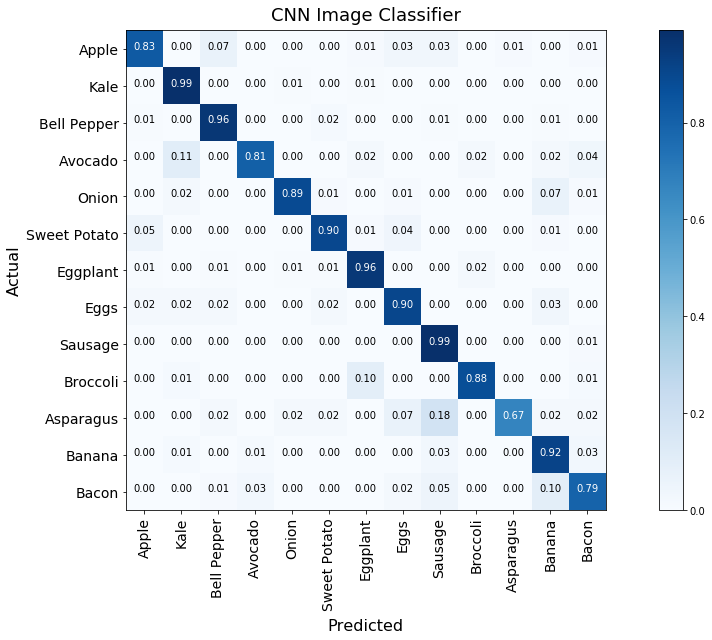

In [30]:
# Plot confusion matrix

plt.figure(figsize = (15, 9))
plot_confusion_matrix(cm, labels=labels,
                      title='CNN Image Classifier')

plt.savefig('../figures/confusion-matrix.png')

### Select dietary and prep time preferences

In [31]:
def pickDietaryPreferences():

    response = input('Do you have any dietary preferences? (yes/no) ')
     
    if response == 'yes':
        print('\nPlease select one of the following: ')
        print('\nLow Carb –– Low Fat –– Low Calorie –– Low Sodium –– Low Cholesterol –– High Protein\n')
        
        dietary_choice = input().lower()
        return dietary_choice
    
    elif response == 'no':
        dietary_choice = 'no'
        return dietary_choice

dietary_choice = pickDietaryPreferences()

Do you have any dietary preferences? (yes/no) 


In [32]:
def pickPrepTime():
    
    response = input('Do you want recipes that can be finished in under 45 minutes? (yes/no) ')
    
    if response == 'yes':
        preptime_choice = 'yes'
        return preptime_choice
    
    return('no')

preptime_choice = pickPrepTime()

Do you want recipes that can be finished in under 45 minutes? (yes/no) 


### Link Model with Recipes

In [38]:
def linkModelWithRecipes(recipe_table, *predictions):

    '''Loop through the model's predictions (as many images as the user uploads) and
    return a random sample of up to 4 recipes that incorporate those ingredients.
    Account for the possibility that there may be fewer than 4 recipes that incorporate
    a range of ingredients with a specific health metric and prep time preference.  
    '''

    try: # 4 recipes
        return recipe_table[np.logical_and.reduce([recipe_table['Ingredients'].str.contains(ingredient) for ingredient in predictions])].sample(4)
    
    except: 
        try: # 3 recipes
            return recipe_table[np.logical_and.reduce([recipe_table['Ingredients'].str.contains(ingredient) for ingredient in predictions])].sample(3)
        
        except:
            try: # 2 recipes
                return recipe_table[np.logical_and.reduce([recipe_table['Ingredients'].str.contains(ingredient) for ingredient in predictions])].sample(2)
            
            except:
                try: # 1 recipe
                    return recipe_table[np.logical_and.reduce([recipe_table['Ingredients'].str.contains(ingredient) for ingredient in   predictions])].sample(1)
                
                except:
                    pass

### Output  recipes based on dietary and time preference

In [39]:
# All recipes

if preptime_choice == 'no':
    
    if dietary_choice == 'no':
        user_specific_recipes = linkModelWithRecipes(df, *predictions)
    elif dietary_choice == 'low carb':
        user_specific_recipes = linkModelWithRecipes(df_low_carb, *predictions)
    elif dietary_choice == 'low calorie':
        user_specific_recipes = linkModelWithRecipes(df_low_calorie, *predictions)  
    elif dietary_choice == 'low fat':
        user_specific_recipes = linkModelWithRecipes(df_low_fat, *predictions)
    elif dietary_choice == 'low sodium':
        user_specific_recipes = linkModelWithRecipes(df_low_sodium, *predictions)
    elif dietary_choice == 'low cholesterol':
        user_specific_recipes = linkModelWithRecipes(df_low_cholesterol, *predictions)
    elif dietary_choice == 'high protein':
        user_specific_recipes = linkModelWithRecipes(df_high_protein, *predictions)
        
# Recipes under 45 minutes
else:
    if dietary_choice == 'no':
        user_specific_recipes = linkModelWithRecipes(df_quick, *predictions)
    elif dietary_choice == 'low carb':
        user_specific_recipes = linkModelWithRecipes(df_low_carb_quick, *predictions)
    elif dietary_choice == 'low calorie':
        user_specific_recipes = linkModelWithRecipes(df_low_calorie_quick, *predictions)  
    elif dietary_choice == 'low fat':
        user_specific_recipes = linkModelWithRecipes(df_low_fat_quick, *predictions)
    elif dietary_choice == 'low sodium':
        user_specific_recipes = linkModelWithRecipes(df_low_sodium_quick, *predictions)
    elif dietary_choice == 'low cholesterol':
        user_specific_recipes = linkModelWithRecipes(df_low_cholesterol_quick, *predictions)
    elif dietary_choice == 'high protein':
        user_specific_recipes = linkModelWithRecipes(df_high_protein_quick, *predictions)

In [322]:
# !jupyter nbconvert --to python "recipes.ipynb" \
# --TemplateExporter.exclude_markdown=False \
# --TemplateExporter.exclude_output_prompt=True \
# --TemplateExporter.exclude_input_prompt=True

[NbConvertApp] Converting notebook recipes.ipynb to python
[NbConvertApp] Writing 16780 bytes to recipes.py
